# Tutorial: simulation of Prox-seq data

**Author: Hoang Van Phan**

**Date: 1/18/2022**

**Tay Lab**

**Pritzker School of Molecular Engineering**

**The University of Chicago**

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# *****Custom Prox-seq functions and classes*****
import ProxseqClasses as PC

## Data simulation

In this simulation, we will simulate 3 proteins (protein 1, protein 2, protein 3). Assume that only protein 1 homodimerizes (i.e., the only protein complex present is 1:1). Furthermore, assume that the average count of protein complex 1:1 is 200 per single cell.

In [2]:
# Set parameters for the protein complexes
num_complex = np.zeros((3,3))
num_complex[0,0] = 200

Next, assume that there are many protein 1 and protein 2 molecules that do not interact with any other proteins, and the average count of such protein 1 and 2 molecules is 500 per single cell. Then, assume that there are on average 10 protein 3 molecules that do not interact with any other proteins.

In [3]:
# Set parameters for the non-interacting proteins
probeA = [500,500,100]
probeB = [500,500,100]

Now, let's simulate the count of PLA products, using the default parameters, with added negative binomial variance

In [4]:
sim = PC.simulatePLA(protein_variance=True)
sim.simulate(num_complex, probeA, probeB)

cell_d=10000. PLA_dist=50.
protein_variance=True. Negative binomial: n=1.5. seed_num=1.
2022-01-20 14:44:03     Start simulation
2022-01-20 14:44:03     Processed     10 cells
2022-01-20 14:44:04     Processed     20 cells
2022-01-20 14:44:05     Processed     30 cells
2022-01-20 14:44:05     Processed     40 cells
2022-01-20 14:44:06     Processed     50 cells
2022-01-20 14:44:06     Processed     60 cells
2022-01-20 14:44:06     Processed     70 cells
2022-01-20 14:44:07     Processed     80 cells
2022-01-20 14:44:07     Processed     90 cells
2022-01-20 14:44:07     Processed    100 cells


Check the size of the simulated PLA product count data.

In [5]:
print(sim.pla_count.shape)

(9, 100)


Plot distribution of PLA products 1:1 and 2:2:

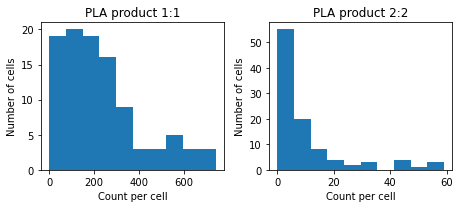

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(6.5,3))
ax[0].hist(sim.pla_count.loc["1:1",:])
ax[0].set_title("PLA product 1:1")
ax[1].hist(sim.pla_count.loc["2:2",:])
ax[1].set_title("PLA product 2:2")
for i in ax:
    i.set_xlabel("Count per cell")
    i.set_ylabel("Number of cells")
fig.tight_layout()

Plot distribution of protein complexes 1:1 and 2:2:

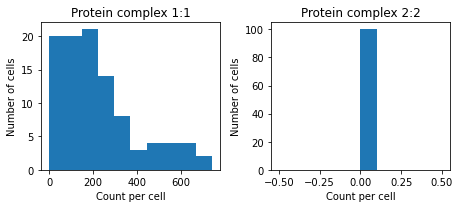

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(6.5,3))
ax[0].hist(sim.complex_count.loc["1:1",:])
ax[0].set_title("Protein complex 1:1")
ax[1].hist(sim.complex_count.loc["2:2",:])
ax[1].set_title("Protein complex 2:2")
for i in ax:
    i.set_xlabel("Count per cell")
    i.set_ylabel("Number of cells")
fig.tight_layout()

## Analyze simulated data

Import simulated PLA product count as plaObject class, and calculate protein abundance:

In [8]:
pla = PC.plaObject(sim.pla_count)
pla.calculateProteinCount()

Compare calculated vs simulated protein abundance. The protein complex and non-interacting proteins both contribute to the simiulated protein abundance, which is what we would measure with flow cytometry or CITE-seq.

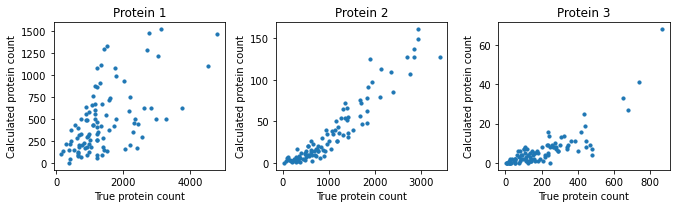

In [9]:
tempA = np.array([s.split(':')[0] for s in sim.complex_count.index])
tempB = np.array([s.split(':')[1] for s in sim.complex_count.index])
fig, ax = plt.subplots(ncols=3, figsize=(9.5,3))
for i in range(3):
    true_protein = (sim.probe_count.loc[f"{i+1}_A",:]+sim.probe_count.loc[f"{i+1}_B",:]+
                    (sim.complex_count.loc[tempA==f"{i+1}",:]+sim.complex_count.loc[tempB==f"{i+1}",:]).sum(axis=0) )
    ax[i].scatter(true_protein, pla.protein_count.loc[f"{i+1}",:], s=10)
    ax[i].set_title(f"Protein {i+1}")
    ax[i].set_xlabel("True protein count")
    ax[i].set_ylabel("Calculated protein count")
fig.tight_layout()

## Predict protein complex count

### Iterative method

Store the predicted protein complex count in pla.complex_count1.

In [10]:
pla.predictComplex(method='iterative', suffix='1')

predictComplex done: Loop number 184, tolerance 1.00


### Linear regression (LR) method

Store the predicted protein complex count in pla.complex_count2. We also need to pass the count of unligated probes to unligated_count parameter.

In [11]:
pla.predictComplex(method='lr', unligated_count=sim.unligated_count, suffix='2')

,intercept,pval_intercept,slope,pval_slope,fdr_intercept,fdr_slope
1:1,154.374347,5.551115e-16,0.000217,1.739028e-01,4.996004e-15,1.739028e-01
1:2,0.623365,9.821276e-01,0.000027,0.000000e+00,1.000000e+00,0.000000e+00
1:3,0.004382,1.000000e+00,0.000028,0.000000e+00,1.000000e+00,0.000000e+00
2:1,0.339472,9.997055e-01,0.000028,0.000000e+00,1.000000e+00,0.000000e+00
2:2,0.070312,1.000000e+00,0.000026,0.000000e+00,1.000000e+00,0.000000e+00
2:3,-0.042231,1.000000e+00,0.000024,0.000000e+00,1.000000e+00,0.000000e+00
3:1,0.001348,1.000000e+00,0.000031,0.000000e+00,1.000000e+00,0.000000e+00
3:2,0.052815,1.000000e+00,0.000027,4.540812e-14,1.000000e+00,5.458134e-14
3:3,-0.002112,1.000000e+00,0.000034,4.851675e-14,1.000000e+00,5.458134e-14


### Compare iterative and LR results

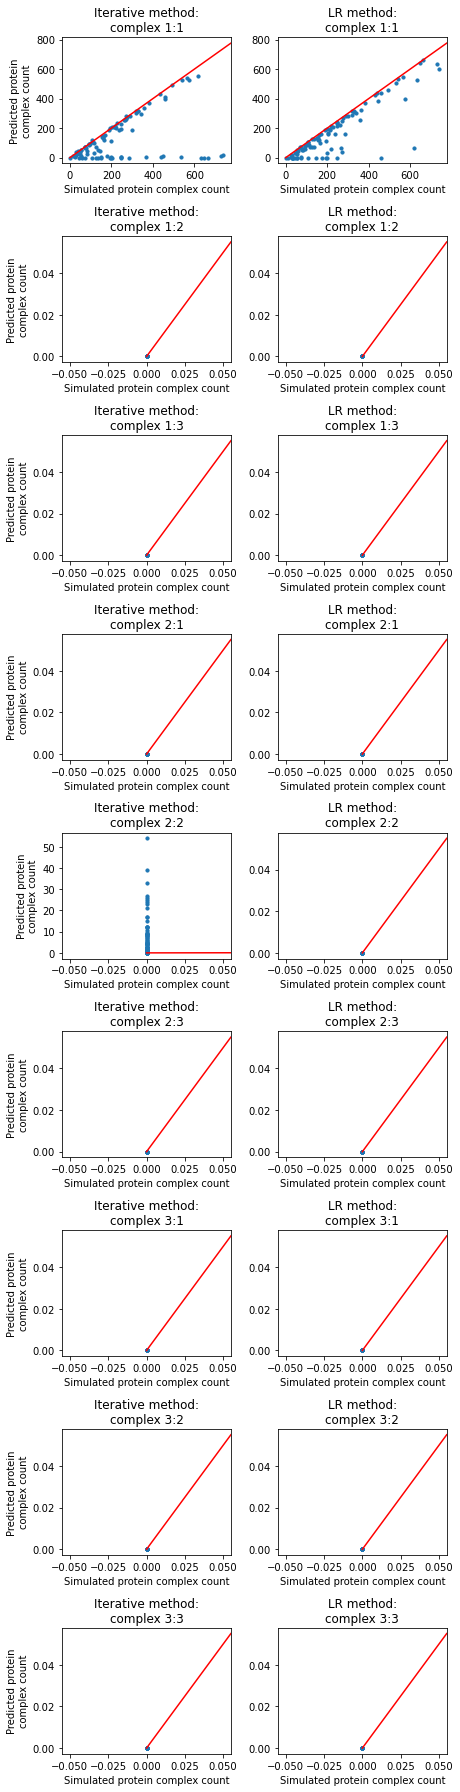

In [12]:
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(6.5,25))
for i, pc in enumerate(pla.pla_count.index):
    ax[i,0].scatter(sim.complex_count.loc[pc,:], pla.complex_count1.loc[pc,:], s=10)
    ax[i,1].scatter(sim.complex_count.loc[pc,:], pla.complex_count2.loc[pc,:], s=10)
    ax[i,0].set_ylabel("Predicted protein\ncomplex count")
    ax[i,0].set_title(f"Iterative method:\ncomplex {pc}")
    ax[i,1].set_title(f"LR method:\ncomplex {pc}")
    for j in range(2):
        ax[i,j].set_xlabel("Simulated protein complex count")
        xmin, xmax = ax[i,j].get_xlim()
        ax[i,j].set_xlim(xmin, xmax)
        ax[i,j].plot([0,xmax], [0,xmax], c='red', lw=1.5)
fig.tight_layout()

## Analyze experiment data

Import PLA product count matrix:

In [13]:
data = pd.read_csv("tutorial_count_matrix.txt.gz", index_col=0, delimiter="\t")

# Filter cells
# Keep cells with > 10 UMIs and below 30k UMIs
data = data.loc[:,(data.sum(axis=0)>10) & (data.sum(axis=0)<30000)]
# Keep cells with more than 20 detected PLA products
data = data.loc[:,((data>0).sum(axis=0)>20)]

Import single Jurkat cells as plaObject class. The name of the probes that corresponds to unligated probes is "free_oligo", so we pass it to the unligated_marker parameter.

In [14]:
pla_J = PC.plaObject(data.loc[:,data.columns.str.contains("Jurkat")], unligated_marker="free_oligo")

Calculate protein abundance:

Text(0.5, 1.0, 'PD1: Jurkat marker\nPDL1: non-Jurkat marker')

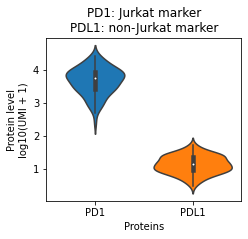

In [15]:
pla_J.calculateProteinCount()

# Plot a Jurkat and a non-Jurkat marker
fig, ax = plt.subplots(figsize=(3.5,3))
sns.violinplot(data=np.log10(pla_J.protein_count.loc[["PD1","PDL1"],:].T+1), ax=ax, saturation=1)
ax.set_xlabel("Proteins")
ax.set_ylabel("Protein level\nlog10(UMI + 1)")
ax.set_title("PD1: Jurkat marker\nPDL1: non-Jurkat marker")

Predict protein complex. For the LR method, because we have already specified the unligated marker earlier, we do not need to pass the count of unligated probes to unligated_count parameter anymore.

In [16]:
pla_J.predictComplex(method='iterative', suffix='1')
pla_J.predictComplex(method='lr', suffix='2')

predictComplex done: Loop number 200, tolerance 2.74


C:\Users\Hoang Van Phan\ProxseqClasses.py:697: RuntimeWarning: divide by zero encountered in double_scalars
  t_intercept = (results.params[0]-mean_cutoff)/results.bse[0]
C:\Users\Hoang Van Phan\ProxseqClasses.py:699: RuntimeWarning: invalid value encountered in double_scalars
  t_slope = (results.params[1]-0)/results.bse[1]


,intercept,pval_intercept,slope,pval_slope,fdr_intercept,fdr_slope
PLA_pair,,,,,,
B7:B7,NaN,NaN,NaN,NaN,NaN,NaN
B7:Biotin,0.000000,1.000000,0.000000,NaN,1.000000,NaN
B7:CD147,0.022938,0.999984,0.007824,0.092866,1.000000,0.159614
B7:CD28,0.028714,0.999990,0.031333,0.267613,1.000000,0.334517
B7:CD3,-0.035110,1.000000,0.022763,0.092368,1.000000,0.159614
...,...,...,...,...,...,...
PDL1:CD3,0.253886,0.999999,0.010363,0.331798,1.000000,0.388274
PDL1:HLADR,NaN,NaN,NaN,NaN,NaN,NaN
PDL1:ICAM1,0.193548,0.999349,-0.055108,0.687610,1.000000,0.727279


Compare the predicted complex counts from both iterative and LR methods.

D:\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, 1.0, 'Jurkat cells express\nCD3, CD28, PD1 and CD147')

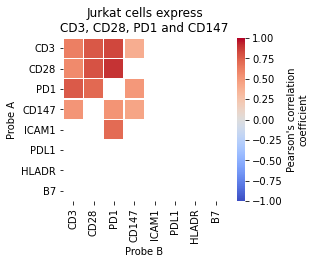

In [17]:
# Calculate Pearson's correlation coefficient between the results of the two methods
pearsons = pd.DataFrame(index=pla_J.pla_count.index, columns=["coef","probeA","probeB"])
for i in pearsons.index:
    pearsons.at[i,'coef'] = stats.pearsonr(pla_J.complex_count1.loc[i,:], pla_J.complex_count2.loc[i,:])[0]
    pearsons.at[i,'probeA'] = i.split(':')[0]
    pearsons.at[i,'probeB'] = i.split(':')[1]
# Infer dtype
pearsons = pearsons.infer_objects()
    
# Pivot data frame
pearsons2 = pearsons.pivot(index="probeA", columns="probeB", values="coef")
    
# Plot heatmap
temp_order = ["CD3","CD28","PD1","CD147","ICAM1","PDL1","HLADR","B7"]
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(data=pearsons2.loc[temp_order,temp_order], ax=ax, cmap='coolwarm', vmin=-1, vmax=1,
            square=True, linewidths=0.5,
            cbar_kws={'label':"Pearson\'s correlation\ncoefficient"})
ax.set_xlabel("Probe B")
ax.set_ylabel("Probe A")
ax.set_title("Jurkat cells express\nCD3, CD28, PD1 and CD147")